# UKBB MVP Finngen summary statistics preparation

This notebook describes the procedure for:
- harmonising UKBB, MVP and Finngen meta analysis `SummaryStatistics`
- preparing `StudyIndex` for the meta analysis

The original data can be found in the `gs://finngen-public-data-r12/meta_analysis/mvp_ukbb/` google cloud storage bucket.

## Setup

Setup session with enhanced bgzip codec for reading bgzipped tsv summary statistics files.

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LabelSet
from bokeh.palettes import Category10, Viridis256
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from pyspark.sql import Column, DataFrame
from pyspark.sql import functions as f
from pyspark.sql import types as t

from gentropy import Session, StudyIndex
from gentropy.common.stats import pvalue_from_neglogpval
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.dataset.variant_direction import VariantDirection
from gentropy.dataset.variant_index import VariantIndex
from gentropy.finngen_ukb_mvp_meta import FinngenUkbbMvpMetaIngestionStep
from gentropy.study_validation import StudyValidationStep


Loading BokehJS ...

/home/ss60/gentropy/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning:

In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.



AssertionError: 

In [ ]:
session = Session(
    spark_uri="yarn",
    extended_spark_conf={
        "spark.master.memory": "16G",
        "spark.driver.maxResultSize": "10G",
    },
    use_enhanced_bgzip_codec=True,
    write_mode="overwrite",
)


25/10/07 09:05:01 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:05:01 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:05:01 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:05:01 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:

In [2]:
## Inputs
source_manifest_path = "gs://finngen-public-data-r12/meta_analysis/mvp_ukbb/FinnGen_R12_MVP_UKBB_manifest.tsv"
source_summary_statistics_glob = (
    "gs://finngen-public-data-r12/meta_analysis/mvp_ukbb/summary_stats/*.gz"
)
efo_curation_path = "https://raw.githubusercontent.com/opentargets/curation/refs/tags/25.09/mappings/disease/manual_string.tsv"
gnomad_variant_index_path = "gs://gnomad_data_2/v4.1/variant_index/"

## Outputs
study_index_output_path = "gs://finngen_ukb_mvp_meta_data/study_index/"
raw_summary_statistics_output_path = (
    "gs://finngen_ukb_mvp_meta_data/raw_summary_statistics/"
)
harmonised_summary_statistics_output_path = (
    "gs://finngen_ukb_mvp_meta_data/harmonised_summary_statistics/"
)

disease_index_path = (
    "gs://open-targets-pipeline-runs/il/25.09-testrun-1/output/disease/"
)
target_index_path = "gs://open-targets-pipeline-runs/il/25.09-testrun-1/output/target/"
biosample_index_path = (
    "gs://open-targets-pipeline-runs/il/25.09-testrun-1/output/biosample/"
)
invalid_qc_reasons = [
    "UNRESOLVED_TARGET",
    "UNRESOLVED_DISEASE",
    "UNKNOWN_STUDY_TYPE",
    "DUPLICATED_STUDY",
    "UNKNOWN_BIOSAMPLE",
    "FAILED_MEAN_BETA_CHECK",
    "FAILED_PZ_CHECK",
    "FAILED_GC_LAMBDA_CHECK",
    "NO_OT_CURATION",
    "CASE_CASE_STUDY_DESIGN",
]
valid_study_index_path = "gs://finngen_ukb_mvp_meta_data/valid_study_index/"
invalid_study_index_path = "gs://finngen_ukb_mvp_meta_data/invalid_study_index/"


In [3]:
def group_statistics(
    df: DataFrame, group_column: Column | list[Column] | str | list[str]
) -> DataFrame:
    """Calculate group statistics.

    the statistics calculated are:
    * count of each group
    * percentage of each group relative to the total count
    """
    if isinstance(group_column, str):
        group_column = [f.col(group_column)]
    elif isinstance(group_column, Column):
        group_column = [group_column]
    total = df.count()
    grouped_df = (
        df.groupBy(group_column)
        .agg(
            f.count("*").alias("count"),
            (f.count("*") / total * 100.0).alias("percentage"),
        )
        .select(
            *group_column,
            f.col("count"),
            f.format_number(f.col("percentage"), 2).alias("%"),
            f.col("percentage"),
        )
        .orderBy(f.desc("count"))
    )

    return grouped_df


## Building StudyIndex

In [ ]:
FinngenUkbbMvpMetaIngestionStep(
    session=session,
    source_manifest_path=source_manifest_path,
    source_summary_statistics_glob=source_summary_statistics_glob,
    efo_curation_path=efo_curation_path,
    gnomad_variant_index_path=gnomad_variant_index_path,
    study_index_output_path=study_index_output_path,
    raw_summary_statistics_output_path=raw_summary_statistics_output_path,
    harmonised_summary_statistics_output_path=harmonised_summary_statistics_output_path,
)


25/10/06 17:58:16 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 17:58:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/10/06 18:04:32 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 81 for reason Container marked as failed: container_1759739267367_0022_01_000082 on host: ot-genetics-dev-000-mindos-sw-tdgk.europe-west1-b.c.open-targets-genetics-dev.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
25/10/06 18:04:32 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 71 for reason Container marked as failed: container_1759739267367_0022_01_000072 on host: ot-genetics-dev-000

25/10/06 18:48:15 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 133 for reason Container marked as failed: container_1759739267367_0022_01_000134 on host: ot-genetics-dev-000-mindos-sw-9hv3.europe-west1-b.c.open-targets-genetics-dev.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
25/10/06 18:48:15 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 83 for reason Container marked as failed: container_1759739267367_0022_01_000084 on host: ot-genetics-dev-000-mindos-sw-1k1q.europe-west1-b.c.open-targets-genetics-dev.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.


## Validating study index

### Reading studyIndex

In [4]:
si = StudyIndex.from_parquet(session, study_index_output_path)
si.df.show()


NameError: name 'session' is not defined

### sample count validation

#### nSamples validation

In [8]:
group_statistics(
    si.df.select(
        f.when(f.col("nSamples").isNull(), f.lit(True))
        .otherwise(f.lit(False))
        .alias("nullNSamples")
    ),
    "nullNSamples",
).show()


+------------+-----+------+----------+
|nullNSamples|count|     %|percentage|
+------------+-----+------+----------+
|       false|  330|100.00|     100.0|
+------------+-----+------+----------+



#### nCases validation

In [ ]:
group_statistics(
    si.df.select(
        f.when(f.col("nCases").isNull(), f.lit(True))
        .otherwise(f.lit(False))
        .alias("nullNCases")
    ),
    "nullNCases",
).show()


+----------+-----+------+----------+
|nullNCases|count|     %|percentage|
+----------+-----+------+----------+
|     false|  330|100.00|     100.0|
+----------+-----+------+----------+



#### nControls validation


In [ ]:
disease_index = (
    session.spark.read.parquet(disease_index_path)
    .select(
        f.col("id").alias("diseaseId"),
        f.explode_outer(
            f.when(
                f.col("obsoleteTerms").isNotNull(),
                f.array_union(f.array("id"), f.col("obsoleteTerms")),
            )
        ).alias("efo"),
    )
    .withColumn("efo", f.coalesce(f.col("efo"), f.col("diseaseId")))
)


### StudyIndex validation step

In [11]:
StudyValidationStep(
    session,
    study_index_path=[study_index_output_path],
    target_index_path=target_index_path,
    disease_index_path=disease_index_path,
    biosample_index_path=biosample_index_path,
    invalid_qc_reasons=invalid_qc_reasons,
    valid_study_index_path=valid_study_index_path,
    invalid_study_index_path=invalid_study_index_path,
)


25/10/07 09:10:43 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:10:44 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:10:44 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:10:49 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/07 09:

#### Valid study count

In [12]:
StudyIndex.from_parquet(session, valid_study_index_path).df.count()


321

#### Invalid study count 

In [13]:
StudyIndex.from_parquet(session, invalid_study_index_path).df.count()


9

#### Reasons for invalid studies

In [ ]:
StudyIndex.from_parquet(session, invalid_study_index_path).df.select(
    "studyId", "qualityControls"
).show(truncate=False)


+-------------------------------------------------------------+-----------------------------------+
|studyId                                                      |qualityControls                    |
+-------------------------------------------------------------+-----------------------------------+
|FINNGEN_R12_UKB_MVP_META_Q17_OTHER_CONGEN_MALFO_DIGES_SYSTEM1|[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_N14_HYPERTROPHYBREAST_BOTH          |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_H7_PERIPHRETINADEGEN                |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_L12_OTHPIGMENTATION                 |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_K11_PARODON_OPER                    |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_D3_ANAEMIA_FOLATEDEF                |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_M13_FINGERDEFORM                    |[No valid disease identifier found]|


### Validation of the ld structure ratios

In [23]:
delta = 1e-10
group_statistics(
    si.df.select(
        f.col("studyId"),
        f.aggregate(
            f.transform(
                f.col("ldPopulationStructure"), lambda x: x["relativeSampleSize"]
            ),
            f.lit(0.0),
            lambda acc, x: acc + x,
        ).alias("totalRelativeSampleSize"),
    ).select(
        f.col("studyId"),
        # Avoid floating point precision issues by checking for not equal
        f.when((f.col("totalRelativeSampleSize") - 1.0 < delta), False)
        .otherwise(True)
        .alias("totalRelativeSampleSizeNotOne"),
    ),
    "totalRelativeSampleSizeNotOne",
).show()


+-----------------------------+-----+------+----------+
|totalRelativeSampleSizeNotOne|count|     %|percentage|
+-----------------------------+-----+------+----------+
|                        false|  330|100.00|     100.0|
+-----------------------------+-----+------+----------+



In [26]:
ld = (
    si.df.select(
        f.col("studyId"),
        f.explode("ldPopulationStructure").alias("ldPopulationStructure"),
    )
    .select(
        f.col("studyId"),
        f.col("ldPopulationStructure.ldPopulation"),
        f.col("ldPopulationStructure.relativeSampleSize"),
    )
    .toPandas()
    .set_index("studyId")
)


ld


,ldPopulation,relativeSampleSize
studyId,,
FINNGEN_R12_UKB_MVP_META_I9_AVBLOCK,fin,0.276361
FINNGEN_R12_UKB_MVP_META_I9_AVBLOCK,nfe,0.601536
FINNGEN_R12_UKB_MVP_META_I9_AVBLOCK,afr,0.085726
FINNGEN_R12_UKB_MVP_META_I9_AVBLOCK,amr,0.036376
FINNGEN_R12_UKB_MVP_META_I9_ABAORTANEUR,fin,0.311917
...,...,...
FINNGEN_R12_UKB_MVP_META_E4_VOLUME,amr,0.033435
FINNGEN_R12_UKB_MVP_META_AB1_ZOSTER,fin,0.326243
FINNGEN_R12_UKB_MVP_META_AB1_ZOSTER,nfe,0.561537


In [124]:
df = ld.reset_index()

# Ensure correct order of populations
pop_order = ["fin", "nfe", "afr", "amr"]

# Sort studies for cleaner layout
df["studyId"] = pd.Categorical(
    df["studyId"], categories=sorted(df.studyId.unique()), ordered=True
)
df["ldPopulation"] = pd.Categorical(
    df["ldPopulation"], categories=pop_order, ordered=True
)

# Bokeh source
source = ColumnDataSource(df)

# Color mapping (0–1 normalized)
mapper = linear_cmap(field_name="relativeSampleSize", palette=Viridis256, low=0, high=1)

# Create heatmap
p = figure(
    x_range=pop_order,
    y_range=sorted(df.studyId.unique(), reverse=True),
    height=1000,
    width=1000,
    title="Relative Sample Size Heatmap (4 Populations)",
    tools="hover,pan,wheel_zoom,reset,save",
    toolbar_location="right",
    tooltips=[
        ("Study", "@studyId"),
        ("Population", "@ldPopulation"),
        ("Relative Size", "@relativeSampleSize{0.000}"),
    ],
)

p.rect(
    x="ldPopulation",
    y="studyId",
    width=1,
    height=1,
    source=source,
    line_color=None,
    fill_color=mapper,
)

# Color bar legend
color_bar = ColorBar(
    color_mapper=mapper["transform"],
    ticker=BasicTicker(desired_num_ticks=10),
    label_standoff=12,
    location=(0, 0),
)
p.add_layout(color_bar, "right")

# Styling
p.yaxis.axis_label = None
p.grid.visible = False
p.title.text_font_size = "10pt"
p.yaxis.axis_label_text_font_size = "6pt"
p.yaxis.visible = False
show(p)


In [ ]:
ld_stats = (
    ld.reset_index()
    .pivot(index="studyId", columns="ldPopulation", values="relativeSampleSize")
    .describe()
    .T.reset_index()
)
ld_stats


,ldPopulation,count,mean,std,min,25%,50%,75%,max
0,afr,256.0,0.082921,0.007763,0.071101,0.078235,0.081210,0.085054,0.119591
1,amr,179.0,0.034356,0.002890,0.029870,0.032748,0.033503,0.035022,0.047374
2,fin,330.0,0.323310,0.048655,0.198060,0.300729,0.322143,0.333933,0.524420
3,nfe,330.0,0.593728,0.051219,0.399119,0.566183,0.586129,0.631195,0.734173


In [ ]:
df = ld_stats

# Create the figure
p = figure(
    x_range=df["ldPopulation"].tolist(),
    height=450,
    width=650,
    title="Relative Sample Size Distribution per Population",
    toolbar_location=None,
    tools="",
)

colors = Category10[len(df)]

# Draw boxplots
for i, row in df.iterrows():
    pop = row["ldPopulation"]
    color = colors[i]

    # Box: Q1–Q3
    p.vbar(
        x=[pop],
        width=0.6,
        bottom=row["25%"],
        top=row["75%"],
        fill_color=color,
        line_color="black",
        alpha=0.8,
    )

    # Median line
    p.segment([pop], [row["50%"]], [pop], [row["50%"]], line_width=3, color="black")

    # Whiskers
    p.segment([pop], [row["max"]], [pop], [row["75%"]], line_color="black")
    p.segment([pop], [row["min"]], [pop], [row["25%"]], line_color="black")

    # Whisker caps
    p.rect([pop], [row["min"]], width=0.2, height=0.0005, line_color="black")
    p.rect([pop], [row["max"]], width=0.2, height=0.0005, line_color="black")

    # Mean point
    p.circle([pop], [row["mean"]], size=8, color="white", line_color="black")

# Axis styling
p.yaxis.axis_label = "Relative Sample Size"
p.xaxis.axis_label = "Population"
p.xgrid.grid_line_color = None
p.title.text_font_size = "14pt"

show(p)


## Variant Annotation (flipping)

In [ ]:
vi = VariantIndex.from_parquet(session, gnomad_variant_index_path)
vd = VariantDirection.from_variant_index(variant_index=vi)
vd.df.show()


+----------+-------------------+----+-------------------+---------+------+-------------+
|chromosome|  originalVariantId|type|          variantId|direction|strand|isPalindromic|
+----------+-------------------+----+-------------------+---------+------+-------------+
|         4|     4_64274529_A_G|   1|     4_64274529_A_G|        1|     1|        false|
|         4|     4_64274529_A_G|   1|     4_64274529_G_A|       -1|     1|        false|
|         4|     4_64274529_A_G|   1|     4_64274529_T_C|        1|    -1|        false|
|         4|     4_64274529_A_G|   1|     4_64274529_C_T|       -1|    -1|        false|
|         4|     4_64274530_G_C|   1|     4_64274530_G_C|        1|     1|         true|
|         4|     4_64274530_G_C|   1|     4_64274530_C_G|       -1|     1|         true|
|         4|     4_64274530_G_C|   1|     4_64274530_C_G|        1|    -1|         true|
|         4|     4_64274530_G_C|   1|     4_64274530_G_C|       -1|    -1|         true|
|         4|     4_64

## Munge summary statistics

### Reading

In [71]:
sst = session.spark.read.parquet(raw_summary_statistics_output_path)


### Check how many fields have missing values

In [ ]:
nullable_check = sst.select(
    f.when(f.col("all_inv_var_meta_sebeta").isNull(), True)
    .otherwise(False)
    .alias("seIsNull"),
    f.when(f.col("all_inv_var_meta_p").isNull(), True)
    .otherwise(False)
    .alias("pvalIsNull"),
    f.when(f.col("all_inv_var_meta_mlogp").isNull(), True)
    .otherwise(False)
    .alias("pvalMlogIsNull"),
    f.when(f.col("all_inv_var_meta_beta").isNull(), True)
    .otherwise(False)
    .alias("betaIsNull"),
)

nullable_stats = group_statistics(
    nullable_check, ["seIsNull", "pvalIsNull", "betaIsNull", "pvalMlogIsNull"]
).toPandas()

nullable_stats


,seIsNull,pvalIsNull,betaIsNull,pvalMlogIsNull,count,%,percentage
0,False,False,False,False,11351651128,83.97,83.967596
1,False,False,True,False,1209288041,8.95,8.945043
2,True,True,False,True,518052308,3.83,3.832007
3,True,True,True,True,277205569,2.05,2.050476
4,False,True,True,True,82318108,0.61,0.608903
5,True,False,False,False,51036551,0.38,0.377515
6,True,False,True,False,27898498,0.21,0.206364
7,True,False,False,True,1635339,0.01,0.012097


25/10/07 09:58:51 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 92 for reason Executor for container container_1759826878691_0001_01_000094 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/07 09:58:51 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 108 for reason Executor for container container_1759826878691_0001_01_000110 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/07 09:58:51 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 120 for reason Executor for container container_1759826878691_0001_01_000122 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/07 09:58:51 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 114 for reason Executor for container container_175982687869

In [79]:
melted = nullable_stats.melt(
    id_vars=["count", "%", "percentage"], var_name="field", value_name="isNull"
)


In [ ]:
output_notebook()

df = melted.copy()
df["isNull_str"] = df["isNull"].astype(str)

# Aggregate percentages by field and isNull
agg = (
    df.groupby(["field", "isNull_str"])["percentage"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# Compute cumulative positions for labels
agg["False_mid"] = agg["False"] / 2
agg["True_mid"] = agg["False"] + agg["True"] / 2
agg["False_label"] = agg["False"].round(2).astype(str) + "%"
agg["True_label"] = agg["True"].round(2).astype(str) + "%"
source = ColumnDataSource(agg)

# Colors for stackers
colors = ["#718dbf", "#e84d60"]  # False = blue, True = red

# Create stacked bar plot
p = figure(
    x_range=agg["field"].tolist(),
    height=400,
    width=800,
    title="Stacked Percentage by Field (False/True)",
    toolbar_location=None,
    tools="",
)

p.vbar_stack(
    stackers=["False", "True"],
    x="field",
    width=0.9,
    color=colors,
    source=source,
    legend_label=["Not Null", "Null"],
)

# Labels for False
labels_false = LabelSet(
    x="field",
    y="False_mid",
    text="False_label",
    source=source,
    text_align="center",
    text_baseline="middle",
    text_color="black",
)

# Labels for True
labels_true = LabelSet(
    x="field",
    y="True_mid",
    text="True_label",
    source=source,
    text_align="center",
    text_baseline="middle",
    text_color="black",
)

p.add_layout(labels_false)
p.add_layout(labels_true)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Field"
p.yaxis.axis_label = "[%]"
p.legend.location = "bottom_right"
p.legend.title = "isNull"

show(p)


Loading BokehJS ...

### Manhattan plot with all variants (except the null p-values)


In [118]:
filtered_sst = (
    sst.filter(f.col("all_inv_var_meta_mlogp").isNotNull())
    .filter(f.col("all_inv_var_meta_beta").isNotNull())
    .filter(f.col("all_inv_var_meta_sebeta").isNotNull())
    .select(
        f.col("#CHR").alias("chromosome"),
        f.col("POS").alias("position"),
        *pvalue_from_neglogpval(f.col("all_inv_var_meta_mlogp")),
    )
    # Add filter on the GWAS significance level, otherwise the data is too large to collect on one node
    .filter(
        (f.col("pValueExponent") < -8)
        | ((f.col("pValueExponent") == -8) & (f.col("pValueMantissa") < 5.0))
    )
)

pd_filtered_sst = filtered_sst.toPandas()


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
25/10/07 10:35:22 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 369 for reason Executor for container container_1759826878691_0001_01_000372 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/07 10:35:22 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 367 for reason Executor for container container_1759826878691_0001_01_000370 exited because of a YARN event (e.g., preemption) and not because of an err

In [ ]:
pd_filtered_sst.shape


(11737127, 4)

/tmp/ipykernel_29205/2646182430.py:67: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/ss60/gentropy/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



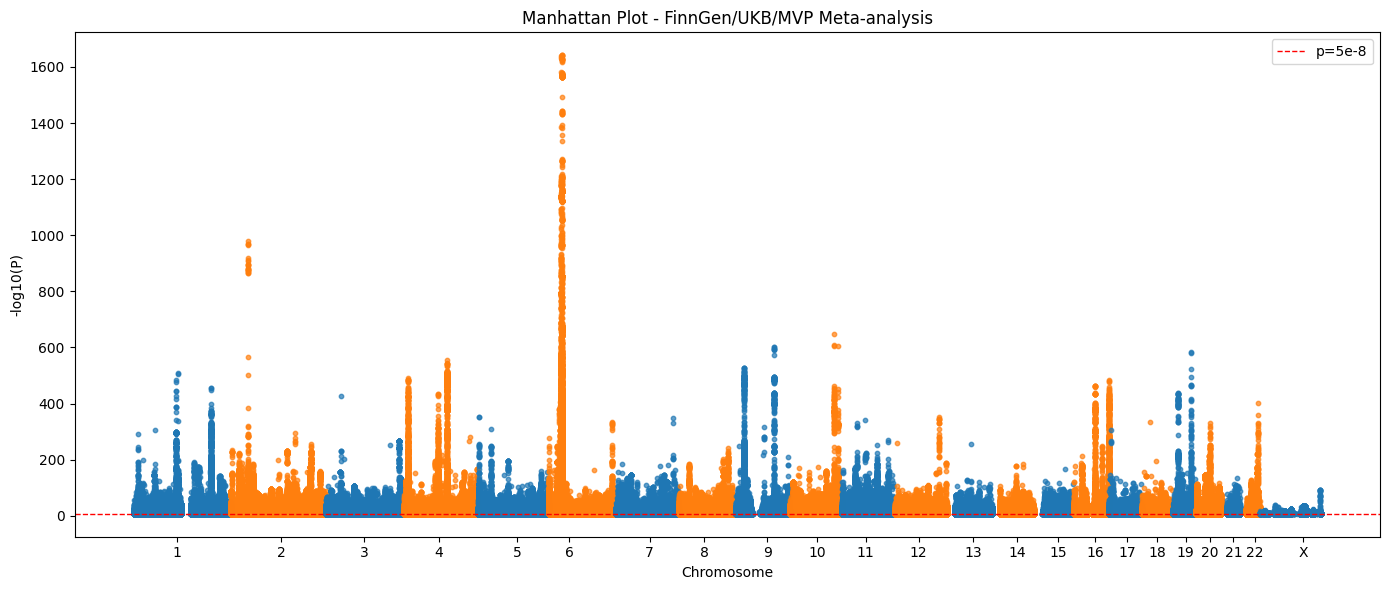

In [122]:
neglog_pval_threshold = -1 * math.log10(5e-8)

# Example dataframe
df = pd_filtered_sst.copy()
df.columns = ["chromosome", "position", "pValueMantissa", "pValueExponent"]
df["-log10P"] = -(df["pValueExponent"] + np.log10(df["pValueMantissa"]))

# Convert chromosome to categorical with proper ordering
df["chromosome"] = df["chromosome"].astype(str)
df["chromosome"] = df["chromosome"].replace("23", "X")
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["chromosome"] = pd.Categorical(
    df["chromosome"], categories=chrom_order, ordered=True
)
df = df.sort_values(by=["chromosome", "position"])

# Calculate cumulative position for x-axis
df["cumulative_pos"] = 0
chromosome_centers = []
last_pos = 0

for chrom in chrom_order:
    if chrom not in df["chromosome"].values:
        continue
    chrom_df = df[df["chromosome"] == chrom]
    df.loc[df["chromosome"] == chrom, "cumulative_pos"] = (
        chrom_df["position"] + last_pos
    )
    # Store center position for chromosome labels
    chromosome_centers.append((chrom, last_pos + chrom_df["position"].median()))
    last_pos = df[df["chromosome"] == chrom]["cumulative_pos"].max()

# Plot
plt.figure(figsize=(14, 6))
colors = ["#1f77b4", "#ff7f0e"]  # Alternating colors

for i, chrom in enumerate(chrom_order):
    if chrom not in df["chromosome"].values:
        continue
    chrom_df = df[df["chromosome"] == chrom]
    plt.scatter(
        chrom_df["cumulative_pos"],
        chrom_df["-log10P"],
        c=colors[i % 2],
        s=10,
        alpha=0.7,
    )

# Add genome-wide significance line
plt.axhline(
    y=neglog_pval_threshold, color="red", linestyle="--", linewidth=1, label="p=5e-8"
)

# Set chromosome labels on x-axis
plt.xticks(
    [pos for _, pos in chromosome_centers],
    [str(chrom) for chrom, _ in chromosome_centers],
    rotation=0,
)

plt.xlabel("Chromosome")
plt.ylabel("-log10(P)")
plt.title("Manhattan Plot - FinnGen/UKB/MVP Meta-analysis")
plt.legend()
plt.tight_layout()
plt.show()


## Building SummaryStatistics

In [ ]:
sumstats = SummaryStatistics(
    _df=sst.filter(f.col("all_inv_var_meta_mlogp").isNotNull())
    .filter(f.col("all_inv_var_meta_beta").isNotNull())
    .filter(f.col("all_inv_var_meta_sebeta").isNotNull())
    .select(
        f.when(
            f.col("#CHR").cast(t.StringType()) == f.lit("23"),
            f.lit("X"),
        ).otherwise(f.col("#CHR").cast(t.StringType()).alias("chromosome")),
        f.col("POS").cast(t.IntegerType()).alias("position"),
        f.col("REF").cast(t.StringType()).alias("reference"),
        f.col("ALT").cast(t.StringType()).alias("alternate"),
        f.col("all_inv_var_meta_beta").alias("beta"),
        f.col("all_inv_var_meta_sebeta").alias("standardError"),
        *pvalue_from_neglogpval(f.col("all_inv_var_meta_mlogp")),
    )
    .select(
        f.col("studyId"),
        f.col("chromosome"),
        f.concat_ws(
            "_",
            f.col("chromosome"),
            f.col("position"),
            f.col("reference"),
            f.col("alternate"),
        ).alias("variantId"),
        f.col("position"),
        f.col("beta"),
        f.col("pValueMantissa"),
        f.col("pValueExponent"),
        f.col("standardError"),
    )
)


In [ ]:
sumstats.df.select(f.col("variantId")).distinct().cache().join(
    vd.df, how="inner", on="variantId"
).drop_duplicates(["variantId"]).count()


25/10/06 23:18:50 WARN CacheManager: Asked to cache already cached data.


43076170

In [ ]:
sumstats.df.select("variantId").distinct().count()


44572866

In [ ]:
type_counts = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "type",
    )
    .cache()
    .toPandas()
)
type_counts


,type,count,%,percentage
0,1.0,40055449,89.87,89.865096
1,3.0,1810795,4.06,4.062550
2,NaN,1496696,3.36,3.357864
3,2.0,1209926,2.71,2.714490


In [ ]:
strand_counts = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "strand",
    )
    .cache()
    .toPandas()
)
strand_counts


,strand,count,%,percentage
0,1.0,43076170,96.64,96.642136
1,NaN,1496696,3.36,3.357864


In [ ]:
direction_counts = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "direction",
    )
    .cache()
    .toPandas()
)
direction_counts


,direction,count,%,percentage
0,1.0,42571034,95.51,95.508855
1,NaN,1496696,3.36,3.357864
2,-1.0,505136,1.13,1.133281


In [ ]:
palindromes = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "isPalindromic",
    )
    .cache()
    .toPandas()
)
palindromes


,isPalindromic,count,%,percentage
0,False,36866233,82.71,82.710035
1,True,6209937,13.93,13.932102
2,None,1496696,3.36,3.357864


In [ ]:
all_groups = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        ["strand", "direction", "type", "isPalindromic"],
    )
    .cache()
    .toPandas()
)
all_groups


,strand,direction,type,isPalindromic,count,%,percentage
0,1.0,1.0,1.0,False,33845512,75.93,75.932995
1,1.0,1.0,1.0,True,6209937,13.93,13.932102
2,1.0,1.0,3.0,False,1539106,3.45,3.453011
3,NaN,NaN,NaN,None,1496696,3.36,3.357864
4,1.0,1.0,2.0,False,976479,2.19,2.190748
5,1.0,-1.0,3.0,False,271689,0.61,0.609539
6,1.0,-1.0,2.0,False,233447,0.52,0.523742


In [ ]:
found_in_gnomad_vi = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .select("variantId", "originalVariantId")
        .distinct()
        .select(
            f.when(f.col("originalVariantId").isNotNull(), True)
            .otherwise(False)
            .alias("foundInVariantDirection")
        ),
        "foundInVariantDirection",
    )
    .cache()
    .toPandas()
)

found_in_gnomad_vi


,foundInVariantDirection,count,%,percentage
0,True,44083486,96.72,96.716345
1,False,1496696,3.28,3.283655


25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 637 for reason Executor for container container_1759739267367_0023_01_000689 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 633 for reason Executor for container container_1759739267367_0023_01_000685 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 649 for reason Executor for container container_1759739267367_0023_01_000701 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 639 for reason Executor for container container_17597392673

## Rescue the EAF

Procedure is as follows:
- Get the ldPopulationStructure and nSamples from the StudyIndex
- Get the individual allele frequencies from all biobanks

1) make sure that if the ancestry has a population structure, allele frequency for it exists
2) if not flag the studyId as invalid
3) if yes, then:
   - 1) if ukbb and finngen are present, then deconvolute their frequencies


In [ ]:
sst.printSchema()


root
 |-- #CHR: string (nullable = true)
 |-- POS: long (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- SNP: string (nullable = true)
 |-- fg_beta: double (nullable = true)
 |-- fg_sebeta: double (nullable = true)
 |-- fg_pval: double (nullable = true)
 |-- fg_af_alt: double (nullable = true)
 |-- fg_af_alt_cases: double (nullable = true)
 |-- fg_af_alt_controls: double (nullable = true)
 |-- MVP_EUR_beta: double (nullable = true)
 |-- MVP_EUR_sebeta: double (nullable = true)
 |-- MVP_EUR_pval: double (nullable = true)
 |-- MVP_EUR_af_alt: double (nullable = true)
 |-- MVP_EUR_r2: double (nullable = true)
 |-- MVP_AFR_beta: double (nullable = true)
 |-- MVP_AFR_sebeta: double (nullable = true)
 |-- MVP_AFR_pval: double (nullable = true)
 |-- MVP_AFR_af_alt: double (nullable = true)
 |-- MVP_AFR_r2: double (nullable = true)
 |-- MVP_HIS_beta: double (nullable = true)
 |-- MVP_HIS_sebeta: double (nullable = true)
 |-- MVP_HIS_pval: double (nul

In [139]:
sst2 = (
    sst.filter(f.col("all_inv_var_meta_mlogp").isNotNull())
    .filter(f.col("all_inv_var_meta_beta").isNotNull())
    .filter(f.col("all_inv_var_meta_sebeta").isNotNull())
    .select(
        f.when(
            f.col("#CHR").cast(t.StringType()) == f.lit("23"),
            f.lit("X"),
        )
        .otherwise(f.col("#CHR").cast(t.StringType()))
        .alias("chromosome"),
        f.col("studyId"),
        f.col("POS").cast(t.IntegerType()).alias("position"),
        f.col("REF").cast(t.StringType()).alias("reference"),
        f.col("ALT").cast(t.StringType()).alias("alternate"),
        f.col("all_inv_var_meta_beta").alias("beta"),
        f.col("all_inv_var_meta_sebeta").alias("standardError"),
        *pvalue_from_neglogpval(f.col("all_inv_var_meta_mlogp")),
        f.struct(
            f.col("fg_af_alt").alias("fg_af"),
            f.col("ukbb_af_alt").alias("ukbb_af"),
            f.col("MVP_AFR_af_alt").alias("mvp_afr_af"),
            f.col("MVP_HIS_af_alt").alias("mvp_his_af"),
            f.col("MVP_EUR_af_alt").alias("mvp_eur_af"),
        ).alias("alleleFrequencies"),
    )
    .select(
        f.col("studyId"),
        f.col("chromosome"),
        f.concat_ws(
            "_",
            f.col("chromosome"),
            f.col("position"),
            f.col("reference"),
            f.col("alternate"),
        ).alias("variantId"),
        f.col("position"),
        f.col("beta"),
        f.col("pValueMantissa"),
        f.col("pValueExponent"),
        f.col("standardError"),
        f.col("alleleFrequencies"),
    )
).limit(100)

si_slice = si.df.select("studyId", "discoverySamples")

joined = sst2.join(si_slice, on="studyId", how="left")

joined.show(truncate=False)


25/10/07 11:38:08 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.


+--------------------------------------+----------+-------------+--------+--------+--------------+--------------+-------------+------------------------------------+-------------------------------------------------------------------------------------+
|studyId                               |chromosome|variantId    |position|beta    |pValueMantissa|pValueExponent|standardError|alleleFrequencies                   |discoverySamples                                                                     |
+--------------------------------------+----------+-------------+--------+--------+--------------+--------------+-------------+------------------------------------+-------------------------------------------------------------------------------------+
|FINNGEN_R12_UKB_MVP_META_I9_HYPTENSESS|1         |1_11063_T_G  |11063   |0.541   |7.2443595     |-1            |1.54         |{NULL, 4.747E-5, NULL, NULL, NULL}  |[{478149, Finnish}, {853973, European}, {116640, African}, {48428, Admixed American

Question: Should we exclude the studies that have just one biobank ?


In [ ]:
sst2.select("variantId", "studyId").distinct().groupBy("studyId").count().orderBy(
    f.desc("count")
).show()
